In [53]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

# Load dataset
df = pd.read_csv("C:/Users/SHIKHAR MISHRA/OneDrive/Desktop/Sample Dataset/Food_Delivery_Time_Prediction.csv")

# Display basic info
print("Dataset shape:", df.shape)
df.head()

Dataset shape: (200, 15)


,Order_ID,Customer_Location,Restaurant_Location,Distance,Weather_Conditions,Traffic_Conditions,Delivery_Person_Experience,Order_Priority,Order_Time,Vehicle_Type,Restaurant_Rating,Customer_Rating,Delivery_Time,Order_Cost,Tip_Amount
0,ORD0001,"(17.030479, 79.743077)","(12.358515, 85.100083)",1.57,Rainy,Medium,4,Medium,Afternoon,Car,4.1,3.0,26.22,1321.10,81.54
1,ORD0002,"(15.398319, 86.639122)","(14.174874, 77.025606)",21.32,Cloudy,Medium,8,Low,Night,Car,4.5,4.2,62.61,152.21,29.02
2,ORD0003,"(15.687342, 83.888808)","(19.594748, 82.048482)",6.95,Snowy,Medium,9,High,Night,Bike,3.3,3.4,48.43,1644.38,64.17
3,ORD0004,"(20.415599, 78.046984)","(16.915906, 78.278698)",13.79,Cloudy,Low,2,Medium,Evening,Bike,3.2,3.7,111.63,541.25,79.23
4,ORD0005,"(14.786904, 78.706532)","(15.206038, 86.203182)",6.72,Rainy,High,6,Low,Night,Bike,3.5,2.8,32.38,619.81,2.34


In [55]:
# Handle missing values
for col in df.columns:
    if df[col].dtype == 'object':
        df[col].fillna(df[col].mode()[0], inplace=True)
    else:
        df[col].fillna(df[col].mean(), inplace=True)

print("✅ Missing values handled successfully.")

✅ Missing values handled successfully.


C:\Users\SHIKHAR MISHRA\AppData\Local\Temp\ipykernel_5584\2597919590.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mode()[0], inplace=True)
C:\Users\SHIKHAR MISHRA\AppData\Local\Temp\ipykernel_5584\2597919590.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a

In [57]:
# Encode categorical features
categorical_cols = ['Weather_Conditions', 'Traffic_Conditions', 'Vehicle_Type']  # example columns
le = LabelEncoder()

for col in categorical_cols:
    df[col] = le.fit_transform(df[col])

print("✅ Categorical columns encoded successfully.")

✅ Categorical columns encoded successfully.


In [59]:
from sklearn.preprocessing import MinMaxScaler

# Initialize scaler
scaler = MinMaxScaler()

# Select continuous features to normalize
continuous_features = ['Distance', 'Delivery_Time']

# Apply normalization (create new scaled columns)
df[continuous_features] = scaler.fit_transform(df[continuous_features])

print("✅ Continuous features normalized successfully!")
print(df[continuous_features].head())

✅ Continuous features normalized successfully!
   Distance  Delivery_Time
0  0.043068       0.105228
1  0.853158       0.453658
2  0.263741       0.317886
3  0.544299       0.923018
4  0.254307       0.164209


In [61]:
import numpy as np
import pandas as pd

# ----------------------------
# Step 1: Clean Location Columns
# ----------------------------
# Remove parentheses and spaces
df['Restaurant_Location'] = df['Restaurant_Location'].str.replace('[()]', '', regex=True).str.strip()
df['Customer_Location'] = df['Customer_Location'].str.replace('[()]', '', regex=True).str.strip()

# ----------------------------
# Step 2: Split into Latitude & Longitude
# ----------------------------
df[['Restaurant_Latitude', 'Restaurant_Longitude']] = df['Restaurant_Location'].str.split(',', expand=True)
df[['Customer_Latitude', 'Customer_Longitude']] = df['Customer_Location'].str.split(',', expand=True)

# Convert to numeric (float)
cols_to_convert = [
    'Restaurant_Latitude', 'Restaurant_Longitude',
    'Customer_Latitude', 'Customer_Longitude'
]
df[cols_to_convert] = df[cols_to_convert].apply(pd.to_numeric, errors='coerce')

# ----------------------------
# Step 3: Define Haversine Function
# ----------------------------
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Earth's radius (km)
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c

# ----------------------------
# Step 4: Apply Haversine Function
# ----------------------------
df['Distance_km'] = df.apply(
    lambda row: haversine(
        row['Restaurant_Latitude'],
        row['Restaurant_Longitude'],
        row['Customer_Latitude'],
        row['Customer_Longitude']
    ), axis=1
)

print("✅ Geographic distance (Haversine) calculated successfully.")
print(df[['Restaurant_Location', 'Customer_Location', 'Distance_km']].head())

✅ Geographic distance (Haversine) calculated successfully.
    Restaurant_Location     Customer_Location  Distance_km
0  12.358515, 85.100083  17.030479, 79.743077   775.651198
1  14.174874, 77.025606  15.398319, 86.639122  1042.385597
2  19.594748, 82.048482  15.687342, 83.888808   476.220706
3  16.915906, 78.278698  20.415599, 78.046984   389.912629
4  15.206038, 86.203182  14.786904, 78.706532   806.505886


In [63]:
scaler = MinMaxScaler()
continuous_cols = ['Distance_km', 'Delivery_Time']  # example continuous columns

df[continuous_cols] = scaler.fit_transform(df[continuous_cols])
print("✅ Continuous features normalized.")

✅ Continuous features normalized.


In [65]:
# Create binary target
df['Delivery_Status'] = df['Delivery_Time'].apply(lambda x: 1 if x > 0.5 else 0)

print("✅ Binary target variable created.")
df[['Delivery_Time', 'Delivery_Status']].head()

✅ Binary target variable created.


,Delivery_Time,Delivery_Status
0,0.105228,0
1,0.453658,0
2,0.317886,0
3,0.923018,1
4,0.164209,0


In [67]:
print("✅ Data Preprocessing Completed Successfully!")
print(df.info())
df.head()

✅ Data Preprocessing Completed Successfully!
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 21 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Order_ID                    200 non-null    object 
 1   Customer_Location           200 non-null    object 
 2   Restaurant_Location         200 non-null    object 
 3   Distance                    200 non-null    float64
 4   Weather_Conditions          200 non-null    int32  
 5   Traffic_Conditions          200 non-null    int32  
 6   Delivery_Person_Experience  200 non-null    int64  
 7   Order_Priority              200 non-null    object 
 8   Order_Time                  200 non-null    object 
 9   Vehicle_Type                200 non-null    int32  
 10  Restaurant_Rating           200 non-null    float64
 11  Customer_Rating             200 non-null    float64
 12  Delivery_Time               200 non-null    flo

,Order_ID,Customer_Location,Restaurant_Location,Distance,Weather_Conditions,Traffic_Conditions,Delivery_Person_Experience,Order_Priority,Order_Time,Vehicle_Type,...,Customer_Rating,Delivery_Time,Order_Cost,Tip_Amount,Restaurant_Latitude,Restaurant_Longitude,Customer_Latitude,Customer_Longitude,Distance_km,Delivery_Status
0,ORD0001,"17.030479, 79.743077","12.358515, 85.100083",0.043068,1,2,4,Medium,Afternoon,2,...,3.0,0.105228,1321.10,81.54,12.358515,85.100083,17.030479,79.743077,0.587518,0
1,ORD0002,"15.398319, 86.639122","14.174874, 77.025606",0.853158,0,2,8,Low,Night,2,...,4.2,0.453658,152.21,29.02,14.174874,77.025606,15.398319,86.639122,0.797649,0
2,ORD0003,"15.687342, 83.888808","19.594748, 82.048482",0.263741,2,2,9,High,Night,1,...,3.4,0.317886,1644.38,64.17,19.594748,82.048482,15.687342,83.888808,0.351630,0
3,ORD0004,"20.415599, 78.046984","16.915906, 78.278698",0.544299,0,1,2,Medium,Evening,1,...,3.7,0.923018,541.25,79.23,16.915906,78.278698,20.415599,78.046984,0.283637,1
4,ORD0005,"14.786904, 78.706532","15.206038, 86.203182",0.254307,1,0,6,Low,Night,1,...,2.8,0.164209,619.81,2.34,15.206038,86.203182,14.786904,78.706532,0.611825,0


In [69]:
# Import essential libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

In [71]:
# Features (X) and Target (y)
X = df.drop(columns=['Delivery_Status'])
y = df['Delivery_Status']

# Split into training and testing sets (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Training Data Shape:", X_train.shape)
print("Testing Data Shape:", X_test.shape)

Training Data Shape: (160, 20)
Testing Data Shape: (40, 20)


In [73]:
# Drop ID columns
df = df.drop(columns=['Order_ID'], errors='ignore')

# Encode categorical features
df = pd.get_dummies(df, drop_first=True)

# Define X and y
X = df.drop('Delivery_Status', axis=1)
y = df['Delivery_Status']

# Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Keep only numeric columns before scaling
X_train = X_train.select_dtypes(include=[np.number])
X_test = X_test.select_dtypes(include=[np.number])

# Scale numeric features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

=== Naive Bayes Classification Report ===
              precision    recall  f1-score   support

           0       1.00      0.94      0.97        17
           1       0.96      1.00      0.98        23

    accuracy                           0.97        40
   macro avg       0.98      0.97      0.97        40
weighted avg       0.98      0.97      0.97        40



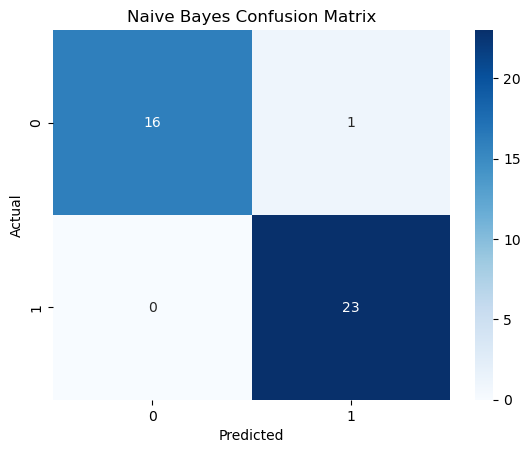

Naive Bayes Accuracy: 0.9750


In [75]:
# Train Gaussian Naive Bayes model
nb_model = GaussianNB()
nb_model.fit(X_train_scaled, y_train)

# Predictions
y_pred_nb = nb_model.predict(X_test_scaled)

# Evaluation
print("=== Naive Bayes Classification Report ===")
print(classification_report(y_test, y_pred_nb))

# Confusion Matrix
cm_nb = confusion_matrix(y_test, y_pred_nb)
sns.heatmap(cm_nb, annot=True, fmt='d', cmap='Blues')
plt.title("Naive Bayes Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Accuracy
print(f"Naive Bayes Accuracy: {accuracy_score(y_test, y_pred_nb):.4f}")

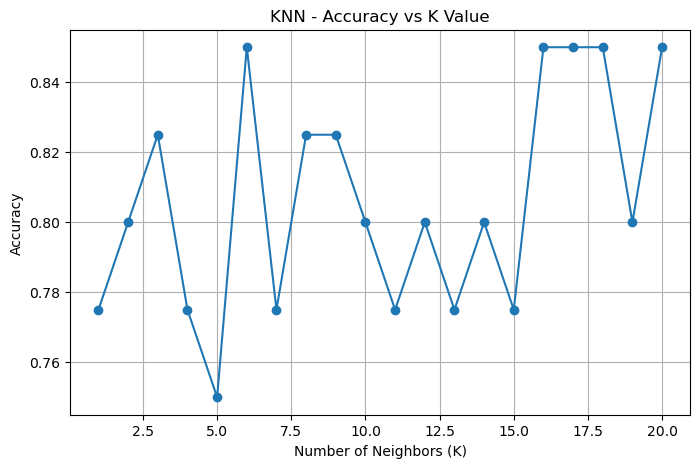

✅ Best K value: 6


In [77]:
# Range of K values to test
k_values = range(1, 21)
accuracies = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)
    y_pred = knn.predict(X_test_scaled)
    accuracies.append(accuracy_score(y_test, y_pred))

# Plot K vs Accuracy
plt.figure(figsize=(8,5))
plt.plot(k_values, accuracies, marker='o')
plt.title("KNN - Accuracy vs K Value")
plt.xlabel("Number of Neighbors (K)")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()

best_k = k_values[np.argmax(accuracies)]
print(f"✅ Best K value: {best_k}")

=== KNN Classification Report ===
              precision    recall  f1-score   support

           0       0.74      1.00      0.85        17
           1       1.00      0.74      0.85        23

    accuracy                           0.85        40
   macro avg       0.87      0.87      0.85        40
weighted avg       0.89      0.85      0.85        40



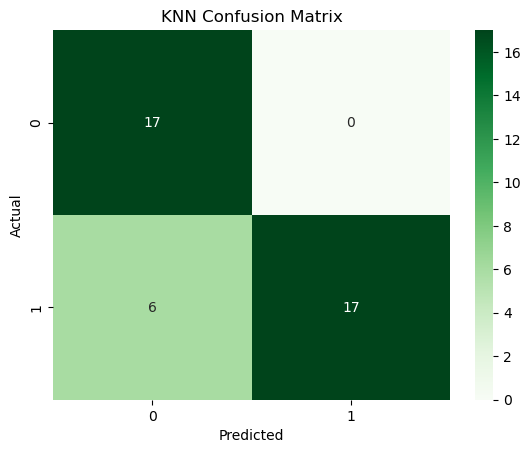

KNN Accuracy: 0.8500


In [79]:
# Train best KNN model
knn_model = KNeighborsClassifier(n_neighbors=best_k)
knn_model.fit(X_train_scaled, y_train)

# Predictions
y_pred_knn = knn_model.predict(X_test_scaled)

# Evaluation
print("=== KNN Classification Report ===")
print(classification_report(y_test, y_pred_knn))

cm_knn = confusion_matrix(y_test, y_pred_knn)
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Greens')
plt.title("KNN Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print(f"KNN Accuracy: {accuracy_score(y_test, y_pred_knn):.4f}")

In [81]:
# Define parameter grid
param_grid = {
    'max_depth': [3, 5, 7, 9, None],
    'min_samples_split': [2, 5, 10, 20]
}

# Grid search with cross-validation
dt_model = DecisionTreeClassifier(random_state=42)
grid_search = GridSearchCV(dt_model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print("✅ Best Parameters for Decision Tree:", best_params)

✅ Best Parameters for Decision Tree: {'max_depth': 3, 'min_samples_split': 2}


=== Decision Tree Classification Report ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        17
           1       1.00      1.00      1.00        23

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40



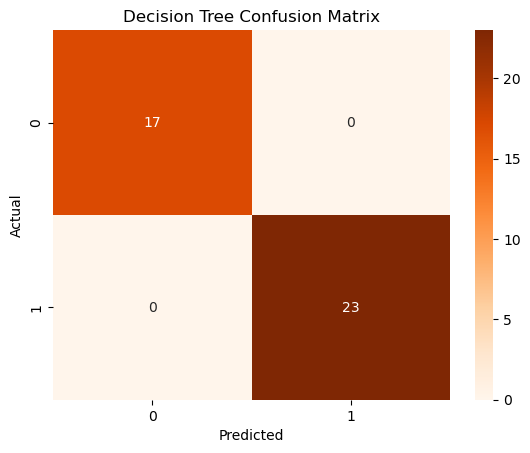

Decision Tree Accuracy: 1.0000


In [82]:
# Train Decision Tree with best parameters
dt_best = DecisionTreeClassifier(**best_params, random_state=42)
dt_best.fit(X_train, y_train)

# Predictions
y_pred_dt = dt_best.predict(X_test)

# Evaluation
print("=== Decision Tree Classification Report ===")
print(classification_report(y_test, y_pred_dt))

cm_dt = confusion_matrix(y_test, y_pred_dt)
sns.heatmap(cm_dt, annot=True, fmt='d', cmap='Oranges')
plt.title("Decision Tree Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print(f"Decision Tree Accuracy: {accuracy_score(y_test, y_pred_dt):.4f}")


=== Model Comparison Summary ===
           Model  Accuracy
0    Naive Bayes     0.975
1            KNN     0.850
2  Decision Tree     1.000


C:\Users\SHIKHAR MISHRA\AppData\Local\Temp\ipykernel_5584\2722165826.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=model_scores, x='Model', y='Accuracy', palette='Set2')


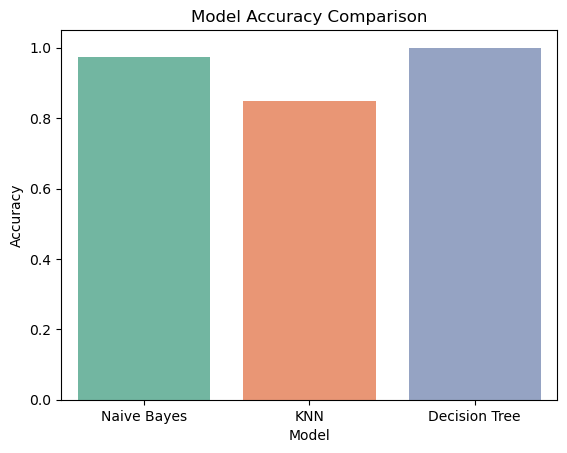

In [85]:
# Compare model performance
model_scores = pd.DataFrame({
    'Model': ['Naive Bayes', 'KNN', 'Decision Tree'],
    'Accuracy': [
        accuracy_score(y_test, y_pred_nb),
        accuracy_score(y_test, y_pred_knn),
        accuracy_score(y_test, y_pred_dt)
    ]
})

print("\n=== Model Comparison Summary ===")
print(model_scores)

sns.barplot(data=model_scores, x='Model', y='Accuracy', palette='Set2')
plt.title("Model Accuracy Comparison")
plt.show()

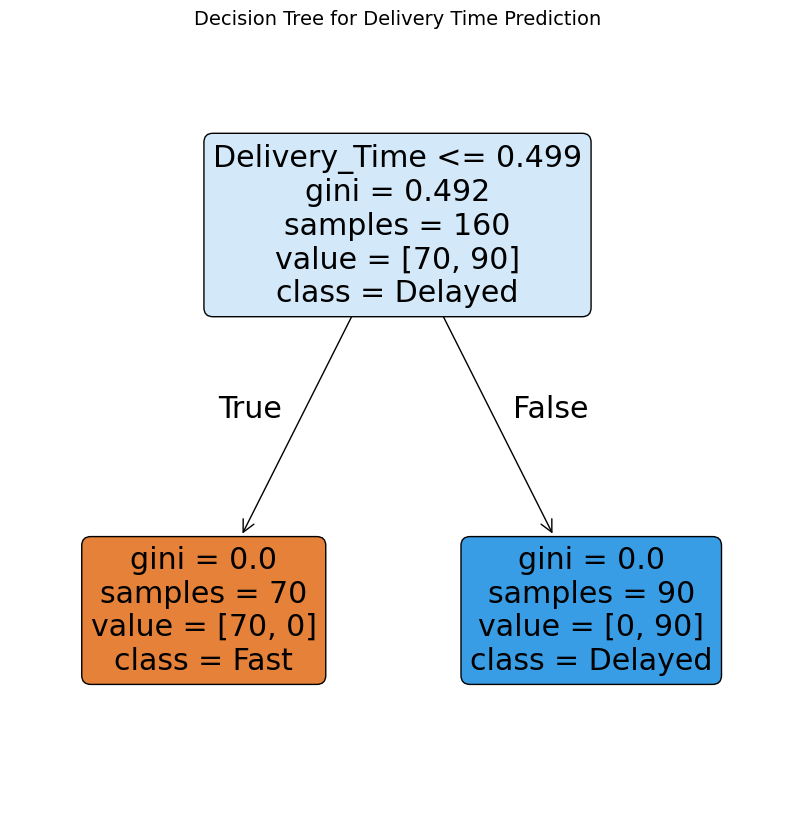

In [95]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt

# Define your features and target
X = df.drop('Delivery_Status', axis=1)   # Features
y = df['Delivery_Status']                # Target (Fast/Delayed)

# Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the Decision Tree
tree_model = DecisionTreeClassifier(max_depth=4, random_state=42)
tree_model.fit(X_train, y_train)

# ✅ Plot the decision tree
plt.figure(figsize=(10,10))
plot_tree(tree_model, filled=True, feature_names=X.columns, class_names=['Fast', 'Delayed'], rounded=True)
plt.title("Decision Tree for Delivery Time Prediction", fontsize=14)
plt.show()

In [99]:
# ✅ Ensure same features used for all models
from sklearn.preprocessing import StandardScaler

# Select only numeric columns (to avoid string/object columns)
X = df.select_dtypes(include=['int64', 'float64'])
y = df['Delivery_Status']  # assuming binary 0 = Fast, 1 = Delayed

# Split data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale numeric features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ✅ Train all models again on same X_train_scaled
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

nb_model = GaussianNB()
nb_model.fit(X_train_scaled, y_train)

knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train_scaled, y_train)

tree_model = DecisionTreeClassifier(max_depth=5, random_state=42)
tree_model.fit(X_train_scaled, y_train)

DecisionTreeClassifier(max_depth=5, random_state=42)

In [101]:
# Evaluate all models
results = {}
models = {
    "Naive Bayes": nb_model,
    "KNN": knn_model,
    "Decision Tree": tree_model
}

for name, model in models.items():
    y_pred = model.predict(X_test_scaled)
    results[name] = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1-Score": f1_score(y_test, y_pred)
    }

import pandas as pd
results_df = pd.DataFrame(results).T
print("📊 Model Comparison Summary:\n")
print(results_df)

📊 Model Comparison Summary:

               Accuracy  Precision  Recall  F1-Score
Naive Bayes         1.0        1.0     1.0       1.0
KNN                 1.0        1.0     1.0       1.0
Decision Tree       1.0        1.0     1.0       1.0


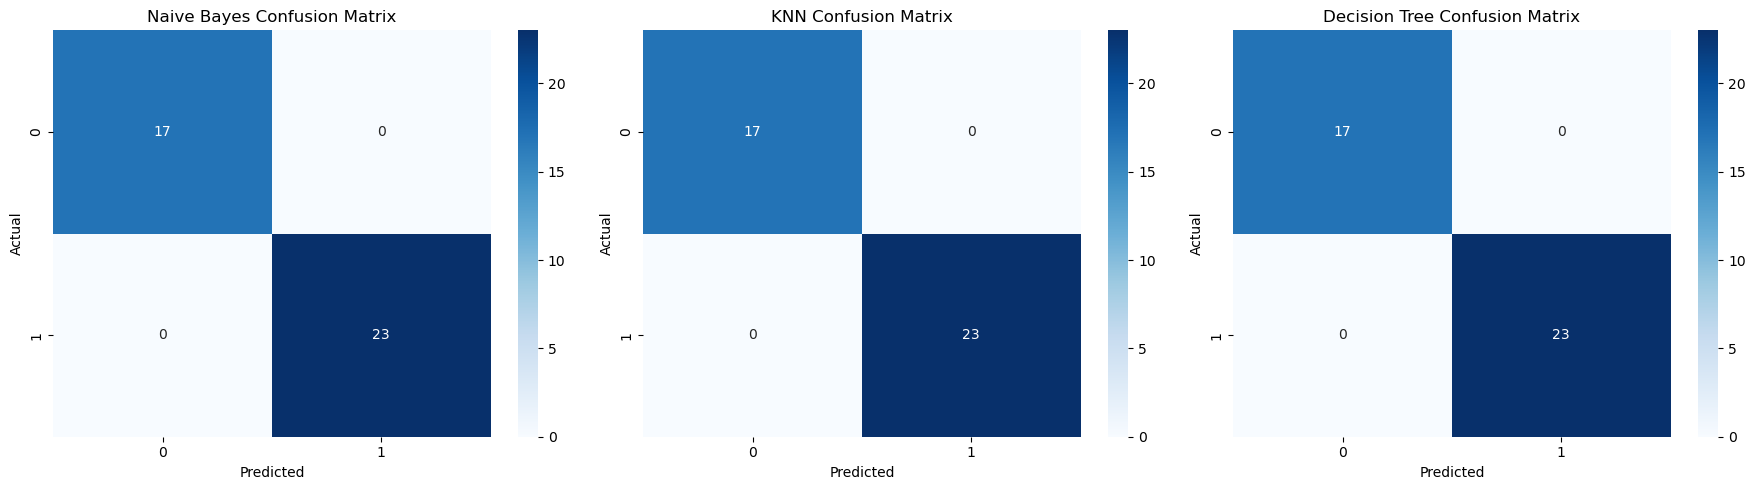

In [103]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for ax, (name, model) in zip(axes, models.items()):
    y_pred = model.predict(X_test_scaled)
    cm = confusion_matrix(y_test, y_pred)
    
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax)
    ax.set_title(f"{name} Confusion Matrix")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")

plt.tight_layout()
plt.show()

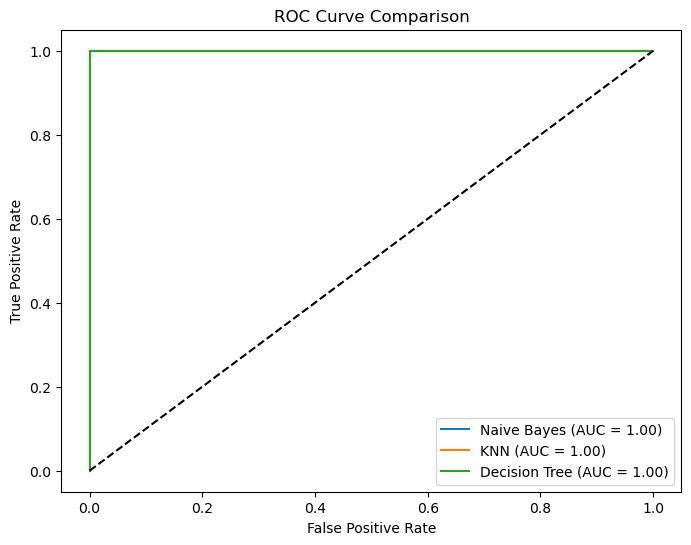

In [105]:
plt.figure(figsize=(8, 6))

for name, model in models.items():
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]  # Probability of class '1' (Delayed)
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal reference line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.show()

In [ ]:
#| Model             | Strengths                                                 | Weaknesses                                   | Use Case                                              |
#| ----------------- | --------------------------------------------------------- | -------------------------------------------- | ----------------------------------------------------- |
#| **Naive Bayes**   | Fast, handles continuous data well, works with small data | Assumes feature independence                 | Baseline or low-resource systems                      |
#| **KNN**           | Simple, non-parametric, interpretable                     | Slower with large data, sensitive to scaling | When interpretability & local decision logic matter   |
#| **Decision Tree** | High interpretability, handles non-linear data            | Prone to overfitting (unless pruned)         | When transparency & rule-based decisioning are needed |
